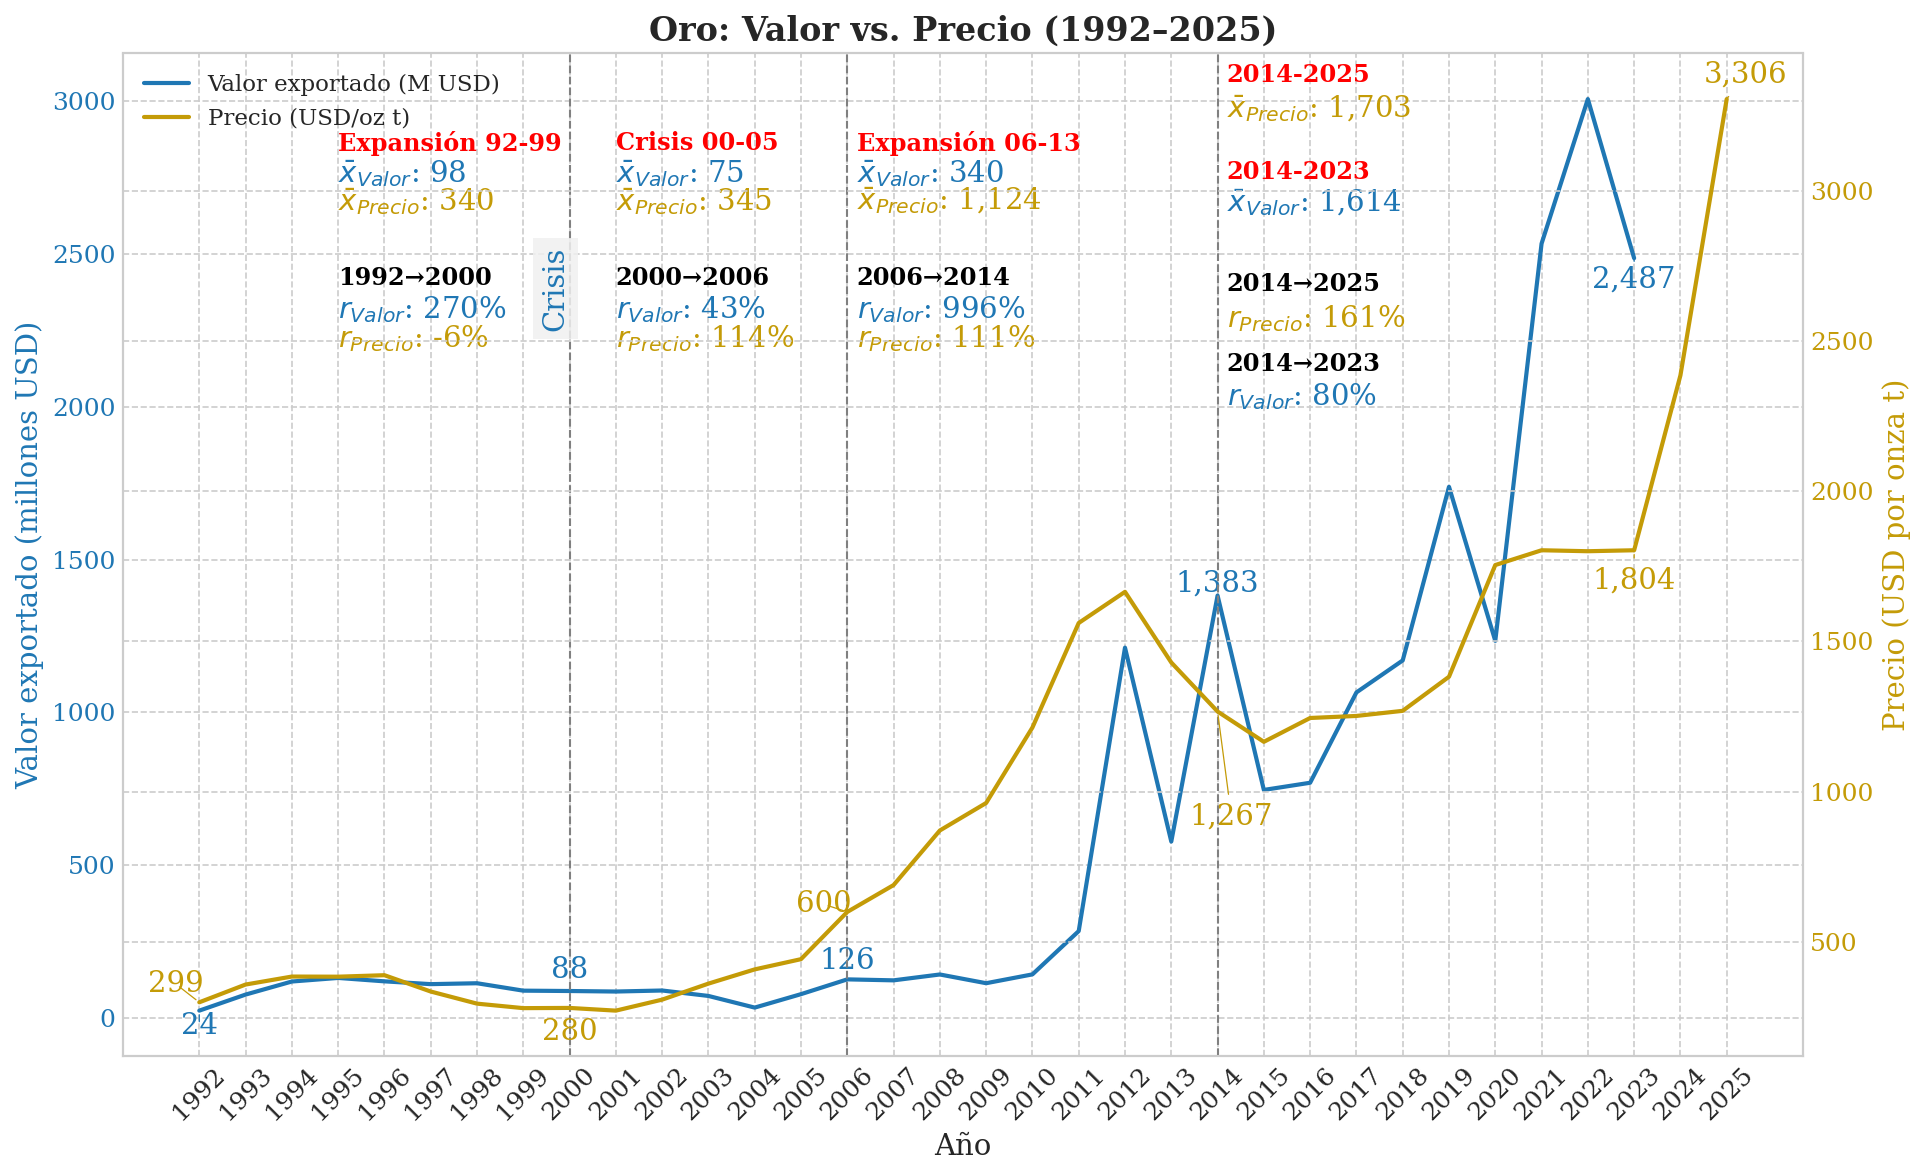

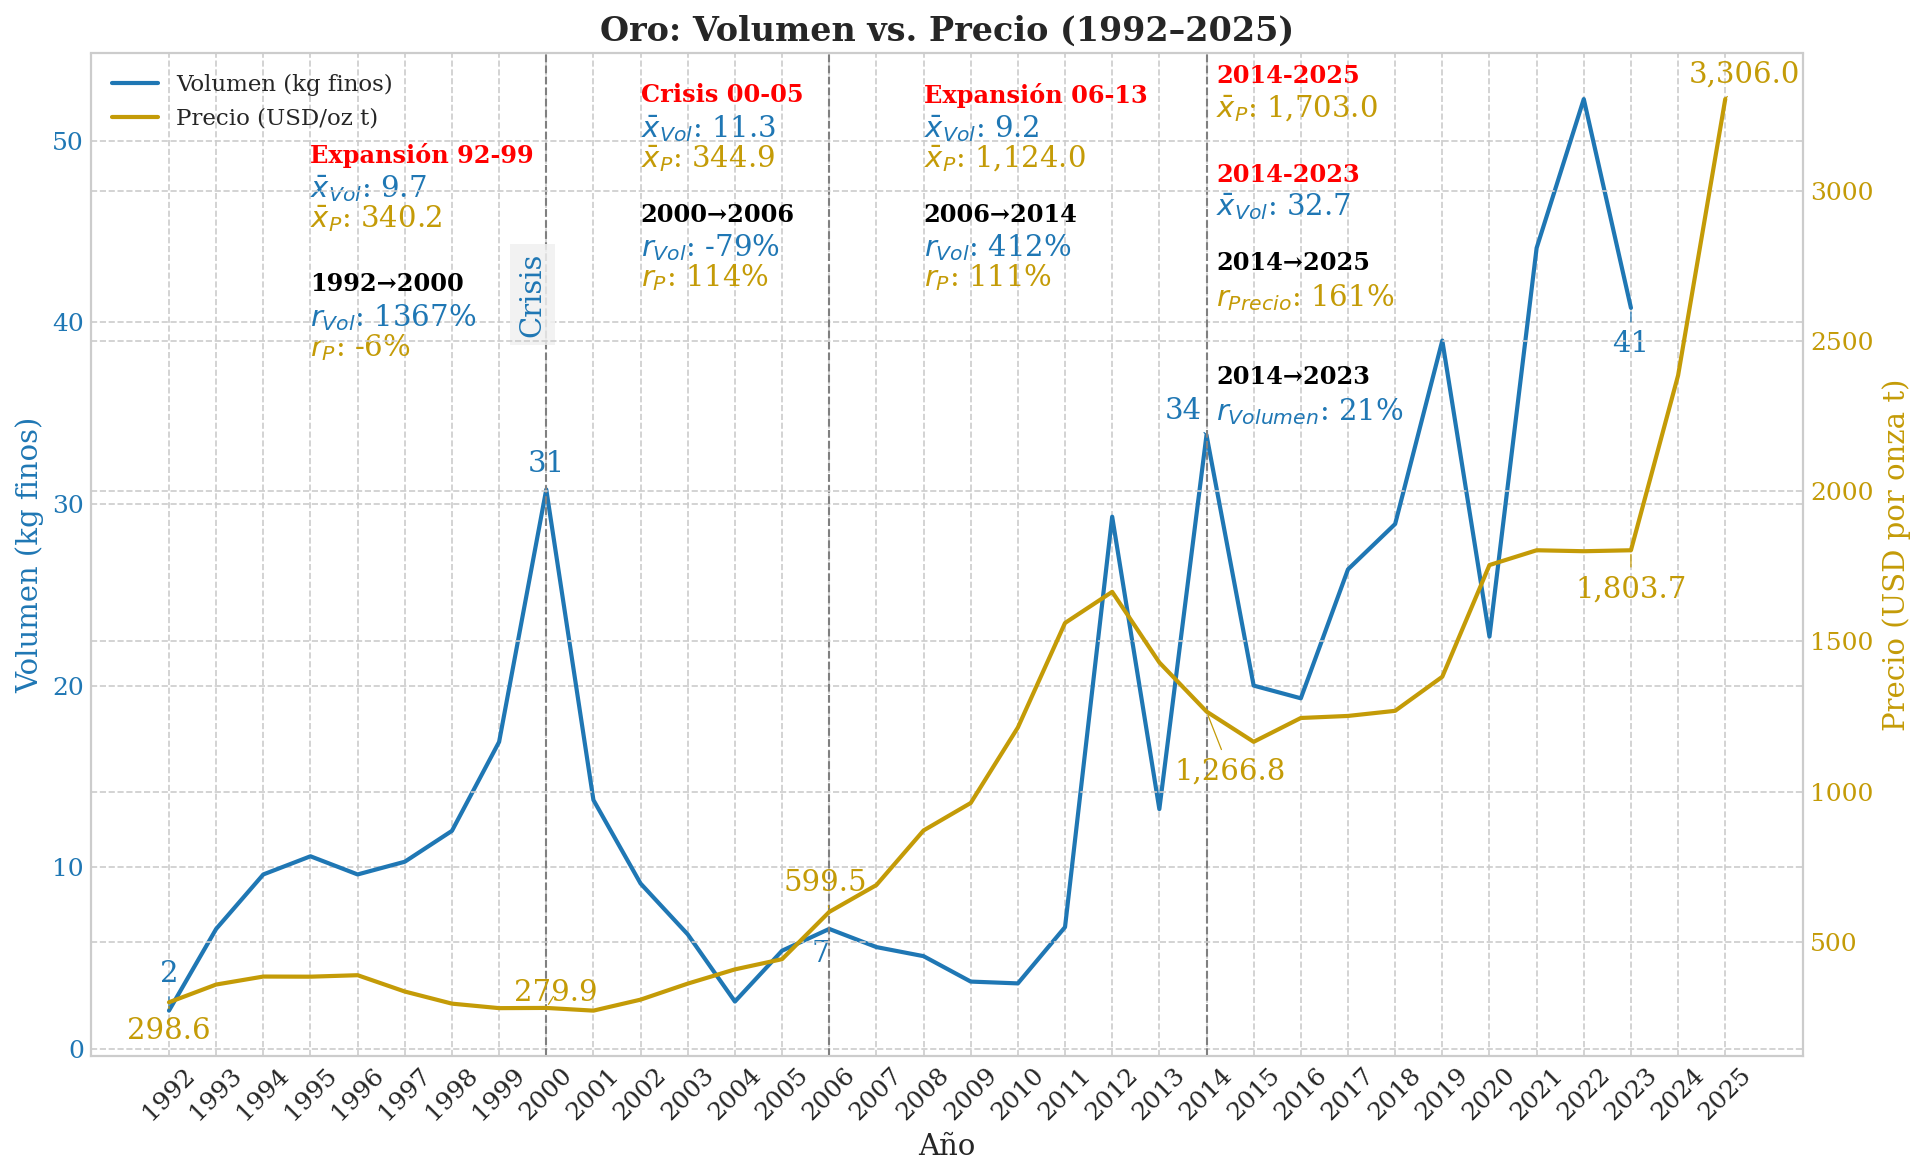

In [89]:
# ─────────────────────────────  PREPARACIÓN  ──────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi
)

# 0. Ciclos y carpetas
periods = {
    "Expansión 92-99": slice(1992, 1999),
    "Crisis 00-05":    slice(2000, 2005),
    "Expansión 06-13": slice(2006, 2013),
}
output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16,   "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150,      "savefig.bbox": "tight",
})

# 1. Datos ────────────────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_oro = (pd.read_sql(
        "SELECT año, oro_volumen, oro_valor "
        "FROM exportaciones_minerales_totales WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )
    df_precio = (pd.read_sql(
        "SELECT año, oro AS precio_usd_ot "
        "FROM precio_oficial_minerales WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )
    df_precio.loc[2025, 'precio_usd_ot'] = 3306.0
    df_precio = df_precio.sort_index()

df = df_oro.join(df_precio, how="outer")
df["oro_valor_musd"] = df["oro_valor"] / 1_000     # miles → millones
df.drop(columns="oro_valor", inplace=True)
df_base = df.loc[:2023]
df_price = df[["precio_usd_ot"]]
# ───────────────────────  GRÁFICA DUAL AXIS (valor-precio) ───────────────────────
cols     = ["oro_valor_musd", "precio_usd_ot"]
abbr     = {"oro_valor_musd": "Valor", "precio_usd_ot": "Precio"}
colors   = {"oro_valor_musd": "#1f77b4", "precio_usd_ot": "#c49b07"}   # azul + dorado
#1f77b4
cycle_stats = {
    n: df.loc[s, cols].mean().to_dict()
    for n, s in periods.items()
}
hitos_v      = {2000: "Crisis", 2006: "Expansión", 2014: "Recesión"}
hitos_offset = {yr: .80 for yr in hitos_v}

anot_years = [1992, 2000, 2006, 2014,2023, 2025]
annotation_offsets = {
    "oro_valor_musd": {   # ajuste manual después de inspeccionar el gráfico
        1992:(0,-50), 2000:(0,70), 2006:(0,60), 2014:(0,40), 2023:(0,-70)
    },
    "precio_usd_ot": {
        1992:(-0.5,60), 2000:(0.0,-80), 2006:(-0.5,25), 2014:(0.3,-350),2023:(0.0,-100), 2025:(0.4,80)
    },
}
# Defino dos listas de periodos:
growth_periods = [(1992,2000),(2000,2006),(2006,2014)]

period_growth_offsets = {
    "1992-2000": (1995,0.78), "2000-2006":(2001,0.78),
    "2006-2014": (2006.2,0.78)
}
cycle_text_offsets = {
    "Expansión 92-99": (1995,0.92),
    "Crisis 00-05":    (2001,0.92),
    "Expansión 06-13": (2006.2,0.92)
}

fig, ax_val = plt.subplots(figsize=(13,8))
ax_price    = ax_val.twinx()

# series
ax_val.plot(df_base.index, df_base["oro_valor_musd"],
            label="Valor exportado (M USD)",
            color=colors["oro_valor_musd"])
ax_price.plot(df_price.index, df_price["precio_usd_ot"],
              label="Precio (USD/oz t)",
              color=colors["precio_usd_ot"])

# helpers
add_hitos(ax_val, df.index, hitos_v, hitos_offset, line_kwargs={"linewidth":1})
add_cycle_means_multi(
    ax_val, cycle_stats, cycle_text_offsets,
    abbr, colors, line_spacing=df["oro_valor_musd"].max()*0.03,
    value_fmt="{:,.0f}"          # 1 decimal para valores pequeños
)
add_cycle_means_multi(
    ax_val, {'2014-2025': {'precio_usd_ot': df.loc[2014:2025,'precio_usd_ot'].mean()}},
    {"2014-2025": (2014.2,0.99)},
    {"precio_usd_ot": "Precio"}, colors, line_spacing=df["precio_usd_ot"].max()*0.03,
    value_fmt="{:,.0f}"          # 1 decimal para valores pequeños
)
add_cycle_means_multi(
    ax_val, {'2014-2023': {'oro_valor_musd': df.loc[2014:2023,'oro_valor_musd'].mean()}},
    {"2014-2023": (2014.2,0.89)},
    {"oro_valor_musd": "Valor"}, colors, line_spacing=df["oro_valor_musd"].max()*0.03,
    value_fmt="{:,.0f}"          # 1 decimal para valores pequeños
)
add_year_value_annotations(
    ax_val,   df, anot_years, ["oro_valor_musd"],
    {"oro_valor_musd": annotation_offsets["oro_valor_musd"]},
    {"oro_valor_musd": colors["oro_valor_musd"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price, df, anot_years, ["precio_usd_ot"],
    {"precio_usd_ot": annotation_offsets["precio_usd_ot"]},
    {"precio_usd_ot": colors["precio_usd_ot"]}, arrow_lw=0.6,
    value_fmt="{:,.0f}"
)


# Tasa sólo para el eje izquierdo (valor, hasta 2024)
add_period_growth_annotations_multi(
    ax_val, df, growth_periods,
    cols,
    period_growth_offsets,
    colors,
    abbr,
)
growth_periods_for_price = [(2014,2025)]
add_period_growth_annotations_multi(
    ax_price, df, growth_periods_for_price,
    ['precio_usd_ot'],
    {
        "2014-2025": (2014.2, 0.79),
    },
    colors,
    {"precio_usd_ot": "Precio"},
)
growth_periods_for_val = [(2014,2023)]
add_period_growth_annotations_multi(
    ax_val, df, growth_periods_for_val,
    ['oro_valor_musd'],
    {
        "2014-2023": (2014.2, 0.69),
    },
    colors,
    {"oro_valor_musd": "Valor"},
)


# etiquetas
ax_val.set_title(f"Oro: Valor vs. Precio ({df.index[0]}–{df.index[-1]})",
                 fontweight="bold")
ax_val.set_xlabel("Año")
ax_val.set_ylabel("Valor exportado (millones USD)",
                  color=colors["oro_valor_musd"])
ax_price.set_ylabel("Precio (USD por onza t)",
                    color=colors["precio_usd_ot"])
ax_val.tick_params(axis="y", labelcolor=colors["oro_valor_musd"])
ax_price.tick_params(axis="y", labelcolor=colors["precio_usd_ot"])
ax_val.set_xticks(df.index[::max(1, len(df)//31)])
ax_val.tick_params(axis="x", rotation=45)

# leyenda filtrada
h,l  = ax_val.get_legend_handles_labels()
h2,l2 = ax_price.get_legend_handles_labels()
hl    = [(x,y) for x,y in zip(h+h2, l+l2) if not y.startswith('_')]
if hl: ax_val.legend(*zip(*hl), loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "oro_valor_precio_dual_axis.png"), dpi=300)
plt.show()

# ──────────────────────  GRÁFICA DUAL AXIS (volumen-precio) ─────────────────────
cols_vol   = ["oro_volumen", "precio_usd_ot"]
colors_vol = {
    "oro_volumen": "tab:blue",          # ya definido
    "precio_usd_ot": colors["precio_usd_ot"]   # dorado del primer gráfico
}
abbr_vol = {"oro_volumen": "Vol", "precio_usd_ot": "P"}

cycle_stats_vol = {
    n: df.loc[s, cols_vol].mean().to_dict()
    for n, s in periods.items()
}

annotation_offsets_vol = {
    "oro_volumen": {
        1992:(0,  2), 2000:(0, 1.4), 2006:(-0.17,-1.4),
        2014:(-0.5,1.3), 2023:(0,-2.0)
    },
    "precio_usd_ot": {
        1992:(0,-95), 2000:(0.2, 50), 2006:(-0.08,95),
        2014:(0.5,-200), 2023:(0.0,-130), 2025:(0.4,80)
    }
}

period_growth_offsets_vol = {
    "1992-2000": (1995,0.78), "2000-2006":(2002,0.85),
    "2006-2014": (2008,0.85), "2014-2024":(2016,0.85)
}

cycle_text_offsets_vol = {
    "Expansión 92-99": (1995,0.91),
    "Crisis 00-05":    (2002,0.97),
    "Expansión 06-13": (2008,0.97),
    "Recesión 14-24":  (2016,0.97),
}

fig_v, ax_v = plt.subplots(figsize=(13,8))
ax_price_v  = ax_v.twinx()

# series
ax_v.plot(df.index, df["oro_volumen"],
          label="Volumen (kg finos)",
          color=colors_vol["oro_volumen"])
ax_price_v.plot(df.index, df["precio_usd_ot"],
                label="Precio (USD/oz t)",
                color=colors_vol["precio_usd_ot"])

# helpers
add_hitos(ax_v, df.index, hitos_v, hitos_offset, line_kwargs={"lw":1})

# espaciado 3 % del rango visible
y_min, y_max  = ax_v.get_ylim()
line_spacing  = (y_max - y_min) * 0.03

# ─── 1) medias estándar de los tres ciclos base (92-99 / 00-05 / 06-13) ───
add_cycle_means_multi(
    ax_v, cycle_stats_vol,              # ← dict con 3 ciclos base
    cycle_text_offsets_vol,
    abbr_vol, colors_vol,
    line_spacing=line_spacing,
    value_fmt="{:,.1f}"
)

# ─── 2) media 2014-2025 SOLO para el precio ──────────────────────────────
mean_price_1425 = {'2014-2025': {'precio_usd_ot': df.loc[2014:2025, 'precio_usd_ot'].mean()}}

add_cycle_means_multi(
    ax_price_v, mean_price_1425,
    {"2014-2025": (2014.2, 0.99)},      # posición del bloque
    {"precio_usd_ot": "P"},
    colors_vol,
    line_spacing=df['precio_usd_ot'].max() * 0.03,
    value_fmt="{:,.1f}"
)

# ─── 3) media 2014-2023 SOLO para el volumen ─────────────────────────────
mean_vol_1423 = {'2014-2023': {'oro_volumen': df.loc[2014:2023, 'oro_volumen'].mean()}}

add_cycle_means_multi(
    ax_v, mean_vol_1423,
    {"2014-2023": (2014.2, 0.89)},      # posición del bloque
    {"oro_volumen": "Vol"},
    colors_vol,
    line_spacing=df['oro_volumen'].max() * 0.03,
    value_fmt="{:,.1f}"
)

add_year_value_annotations(
    ax_v, df, anot_years, ["oro_volumen"],
    {"oro_volumen": annotation_offsets_vol["oro_volumen"]},
    {"oro_volumen": colors_vol["oro_volumen"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price_v, df, anot_years, ["precio_usd_ot"],
    {"precio_usd_ot": annotation_offsets_vol["precio_usd_ot"]},
    {"precio_usd_ot": colors_vol["precio_usd_ot"]}, arrow_lw=0.6,
    value_fmt="{:,.1f}"
)

add_period_growth_annotations_multi(
    ax_v, df, growth_periods, cols_vol,
    period_growth_offsets_vol, colors_vol, abbr_vol,
    line_spacing_ratio=0.03
)
growth_periods_for_price = [(2014,2025)]
add_period_growth_annotations_multi(
    ax_price_v, df, growth_periods_for_price,
    ['precio_usd_ot'],
    {
        "2014-2025": (2014.2, 0.81),
    },
    colors_vol,
    {"precio_usd_ot": "Precio"},
)
growth_periods_for_vol = [(2014,2023)]
add_period_growth_annotations_multi(
    ax_price_v, df, growth_periods_for_vol,
    ['oro_volumen'],
    {
        "2014-2023": (2014.2, 0.7),
    },
    colors_vol,
    {"oro_volumen": "Volumen"},
)
# etiquetas
ax_v.set_title(f"Oro: Volumen vs. Precio ({df.index[0]}–{df.index[-1]})",
               fontweight="bold")
ax_v.set_xlabel("Año")
ax_v.set_ylabel("Volumen (kg finos)", color=colors_vol["oro_volumen"])
ax_price_v.set_ylabel("Precio (USD por onza t)", color=colors_vol["precio_usd_ot"])

ax_v.tick_params(axis="y", labelcolor=colors_vol["oro_volumen"])
ax_price_v.tick_params(axis="y", labelcolor=colors_vol["precio_usd_ot"])
ax_v.set_xticks(df.index[::max(1, len(df)//31)])
ax_v.tick_params(axis="x", rotation=45)

# leyenda combinada
h1,l1 = ax_v.get_legend_handles_labels()
h2,l2 = ax_price_v.get_legend_handles_labels()
ax_v.legend(h1+h2, l1+l2, loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "oro_volumen_precio_dual_axis.png"), dpi=300)
plt.show()



In [90]:
df

,oro_volumen,precio_usd_ot,oro_valor_musd
año,,,
1992,2.1,298.62,23.7585
1993,6.6,357.75,76.3098
1994,9.6,384.33,119.0958
1995,10.6,383.91,130.8105
1996,9.6,388.84,119.6487
1997,10.3,334.51,110.4902
1998,12.0,294.16,113.4286
1999,16.9,279.19,89.1366
2000,30.8,279.88,87.9919
